# Weight Uncertainty Using TensorFlow Probability

Reference:
* https://towardsdatascience.com/uncertainty-in-deep-learning-epistemic-uncertainty-and-bayes-by-backprop-e6353eeadebb

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

2022-03-16 17:06:17.084353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2


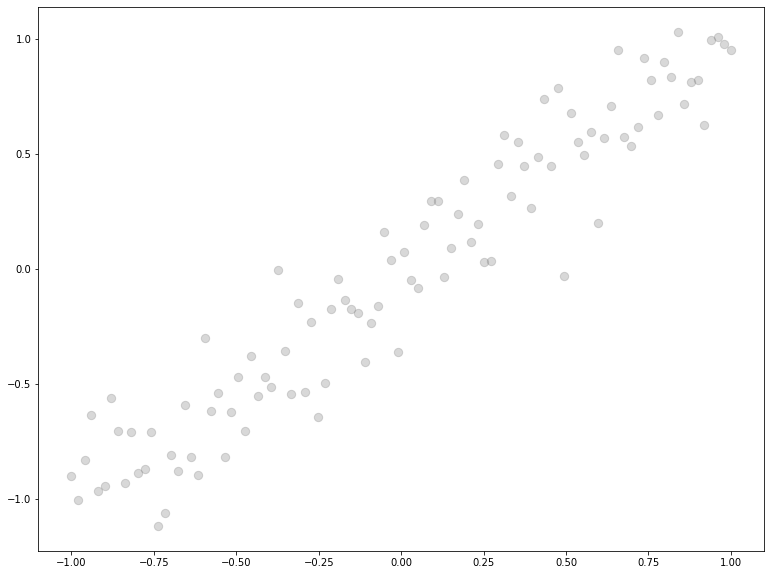

In [2]:
x_100 = np.linspace(-1, 1, 100)
y_100 = x_100 + np.random.randn(x_100.shape[0]) * 0.2

plt.figure(figsize = (13, 10))
plt.scatter(x_100, y_100, color = 'gray', s = 70, alpha = 0.3, marker = "o")

In [3]:
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfpl.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= tf.ones(n))
       )                     
  ])

In [4]:
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n),
    ])

## Equation of Minibatches & Re-Weighting the KL-Divergence

$$
\mathcal{L}(\phi|x)=\frac{1}{M}D_{KL}(Q(\Theta|\phi)||P(\Theta)) - \frac{1}{\text{BatchSize}} \sum_{i=0}^{\text{BatchSize}} log P((x_i, y_i)|\Theta_i)
$$

In [5]:
model_100 = Sequential([
    tfpl.DenseVariational(input_shape = (1,),
                          units = 1,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x_100.shape[0])
])
model_100.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 0.003))
"""
we haven't put a distribution on the output, all the uncertainties in the weights.
So we can still use a normal deterministic loss-function
"""

model_100.summary()

model_100.fit(x_100, y_100, epochs=1000, verbose=0)
model_100.evaluate(x_100, y_100)

2022-03-16 17:06:19.436548: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-16 17:06:19.437282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-16 17:06:19.525582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-03-16 17:06:19.526700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-03-16 17:06:19.527798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:09:00.0 name: GeForc

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


2022-03-16 17:06:23.016230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


4/4 [==============================] - 0s 2ms/step - loss: 0.1015


0.1014782041311264

In [6]:
# Check mean, and variance of variational posterior and prior.
dummy = np.array([[0.0324]])
prior_protected = model_100.layers[0]._prior(dummy) 
posterior_protected = model_100.layers[0]._posterior(dummy)
print('prior mean:', prior_protected.mean().numpy()) # [0. 0.]
print('prior variance:', prior_protected.variance().numpy()) # [1.9999999 1.9999999]
print('posterior mean:', posterior_protected.mean().numpy()) # [ 0.99621785 -0.02372155]
print('posterior variance:', posterior_protected.variance().numpy()) # [0.03062892 0.0123959]

prior mean: [0. 0.]
prior variance: [1.9999999 1.9999999]
posterior mean: [ 0.99621785 -0.02372155]
posterior variance: [0.03062892 0.0123959 ]


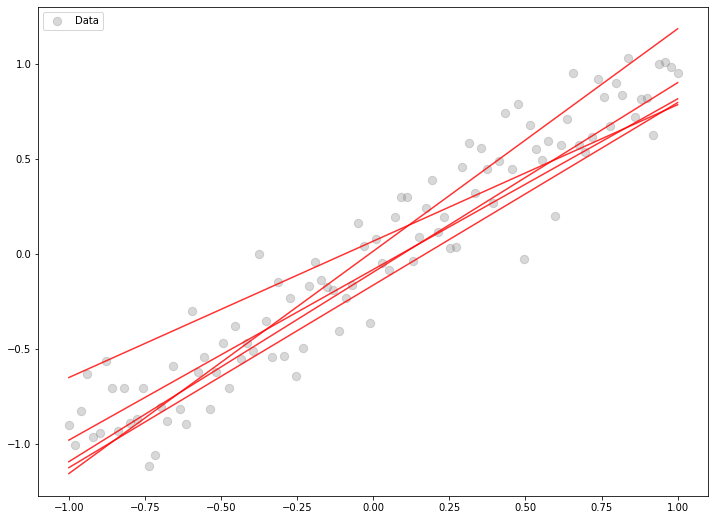

In [7]:
ensemble_size = 5

plt.figure(figsize=(12,9))
plt.scatter(x_100, y_100, s = 70, alpha = 0.3, marker = "o", label = 'Data', color = 'gray')
for _ in range(ensemble_size):
    plt.plot(x_100, model_100(x_100[..., np.newaxis]), color='red', alpha=0.8)        
plt.legend()
plt.show()

# Weight Uncertainty in Non-Linear Regression

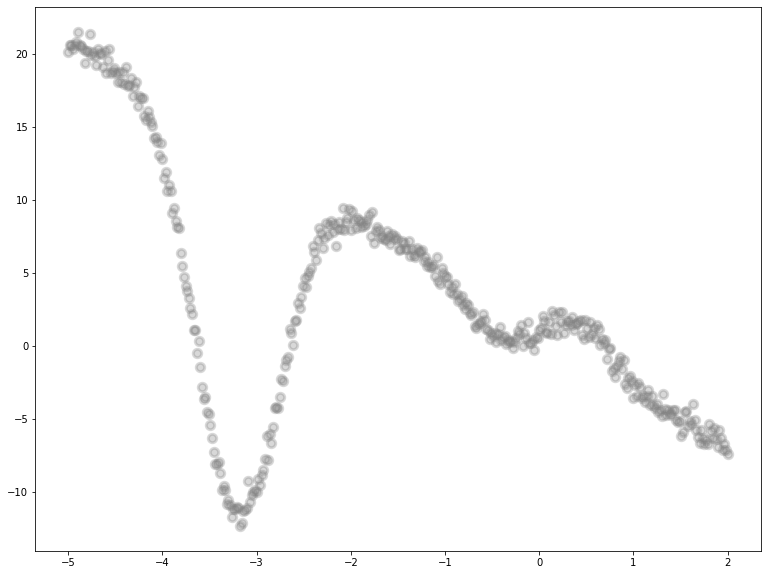

In [8]:
x = np.linspace(-5, 2, 400)
y = 4 * x * np.cos(np.pi * np.sin(x)) + 1 + np.random.randn(x.shape[0]) * 0.5

plt.figure(figsize = (13, 10))
plt.scatter(x, y, color = 'gray', s = 70, alpha = 0.3, marker = "o", label = 'Data',
           linewidth = 3)

In [9]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfpl.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= 2 * tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(

          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

In [10]:
model_non_linear = Sequential([
    
    tfpl.DenseVariational(input_shape = (1,),
                          units = 128,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x.shape[0], activation = tf.nn.silu),
    
    tfpl.DenseVariational(units = 64,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x.shape[0], activation = tf.nn.silu),
    tfpl.DenseVariational(units = 1,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / x.shape[0])
])

model_non_linear.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = tf.keras.optimizers.Adam(lr = 0.003))
model_non_linear.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 128)               512       
_________________________________________________________________
dense_variational_2 (DenseVa (None, 64)                16512     
_________________________________________________________________
dense_variational_3 (DenseVa (None, 1)                 130       
Total params: 17,154
Trainable params: 17,154
Non-trainable params: 0
_________________________________________________________________


In [11]:
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
        tfpl.MultivariateNormalTriL(n)                        
    ])

In [ ]:
model_non_linear.fit(x, y, epochs=1000, verbose=0)
model_non_linear.evaluate(x, y)

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(x, y, s = 70, alpha = 0.3, marker = "o", label = 'Data', color = 'gray')
for _ in range(ensemble_size):
    plt.plot(x, model_non_linear(x[..., np.newaxis]), color='red', alpha=0.8)        
plt.legend()
plt.show()